<a href="https://colab.research.google.com/github/GoelPratyush/JointClassifierandRegressor/blob/main/UV_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip the rar files contaning dataset

In [ ]:
!unrar x "/content/new_metals.rar" "/content/new_metals/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/new_metals.rar

Creating    /content/new_metals                                       OK
Creating    /content/new_metals/new_metals                            OK
Creating    /content/new_metals/new_metals/test                       OK
Creating    /content/new_metals/new_metals/test/cd                    OK
Extracting  /content/new_metals/new_metals/test/cd/Cd_interact_with_H2TPP.xlsx       9%  OK 
Creating    /content/new_metals/new_metals/test/co                    OK
Extracting  /content/new_metals/new_metals/test/co/Co_with_H2TPP_baseline_correction.xlsx      18%  OK 
Creating    /content/new_metals/new_metals/test/hg                    OK
Extracting  /content/new_metals/new_metals/test/hg/Interaction_of_Hg_with_H2TPP.xlsx      27%  OK 
Creating    /content/new_metals/new_metals/test/pb                    OK
Extracting  /content/new_metals/new_metals/test/pb/inter

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle

#Hyperparameters

In [ ]:
features_dim = 551
num_sheets = []
num_sheets_test = []

# Loading the train and test dataset into numpy array of type Embedding

In [ ]:
class Embedding():
    def __init__(self, metal=None, label=None, spectra=None, concentration=None):
        # name of metal
        self.metal = metal
        # label of metal
        self.label = label
        # spectra stored as np array
        self.spectra = spectra
        # concentration
        self.concentration = concentration

    def __repr__(self):
        return "metal: "+self.metal+" "+"concentration: "+str(self.concentration)

    def __call__(self):
        return self.spectra

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.file_path()

    def file_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata_train = []
    metadata_test = []
    identityMetadata = IdentityMetadata
    for i in os.listdir(os.path.join(path, 'train')):
        for f in os.listdir(os.path.join(path, 'train', i)):
            # Check file extension. Allow only xlsx files.
            ext = os.path.splitext(f)[1]
            if ext == '.xlsx':
                metadata_train.append(identityMetadata(os.path.join(path, 'train'), i, f))
    for i in os.listdir(os.path.join(path, 'test')):
        for f in os.listdir(os.path.join(path, 'test', i)):
            # Check file extension. Allow only xlsx files.
            ext = os.path.splitext(f)[1]
            if ext == '.xlsx':
                metadata_test.append(identityMetadata(os.path.join(path,'test'), i, f))
    return np.array(metadata_train),np.array(metadata_test)

def count_sheets(path):
    df = pd.read_excel(path,None)
    return len(df.keys())

def load_spectra(path, sheet):
    df = pd.read_excel(path,sheet_name=sheet)
    spectra = np.asarray(df["Subtracted_Data Y1"][:features_dim])
    return spectra

def load_concentration(path,sheet):
    df = pd.read_excel(path,sheet_name=sheet)
    concentration = df['Concentration (mM)'][0]
    return concentration

In [ ]:
from progressbar import ProgressBar
metadata_train, metadata_test = load_metadata('/content/new_metals/new_metals')
for i, m in enumerate(metadata_train):
    num_sheets.append(count_sheets(m.file_path()))
for i, m in enumerate(metadata_test):
    num_sheets_test.append(count_sheets(m.file_path()))

num_metals = metadata_train.shape[0]
progress = ProgressBar(num_metals)
progress.start()

embedded_train = np.asarray([Embedding() for i in range(sum(num_sheets))])
embedded_test = np.asarray([Embedding() for i in range(sum(num_sheets_test))])
for i, m in enumerate(metadata_train):
    for sheet in range(num_sheets[i]):
        embedded_train[sum(num_sheets[:i])+sheet].spectra = load_spectra(m.file_path(), sheet)
        embedded_train[sum(num_sheets[:i])+sheet].concentration = load_concentration(m.file_path(), sheet)
        embedded_train[sum(num_sheets[:i])+sheet].metal = m.name
        progress.update(sum(num_sheets[:i])+sheet)

for i, m in enumerate(metadata_test):
    for sheet in range(num_sheets_test[i]):
        embedded_test[sum(num_sheets_test[:i])+sheet].spectra = load_spectra(m.file_path(), sheet)
        embedded_test[sum(num_sheets_test[:i])+sheet].concentration = load_concentration(m.file_path(), sheet)
        embedded_test[sum(num_sheets_test[:i])+sheet].metal = m.name
        progress.update(sum(num_sheets_test[:i])+sheet)

\ |           #                                      | 11 Elapsed Time: 0:00:08

#Visualization of training dataset

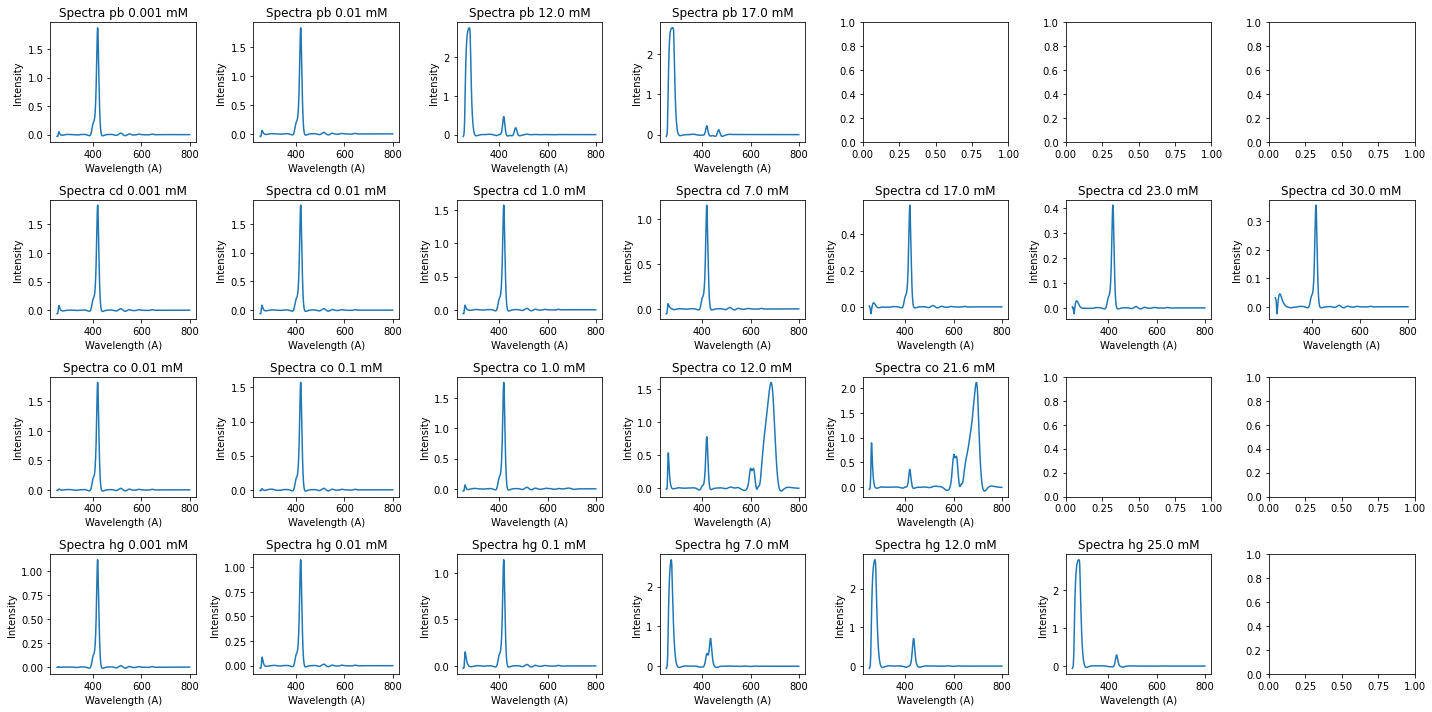

In [ ]:
y = np.arange(800,800-features_dim,-1)

fig, axs = plt.subplots(nrows=num_metals, ncols=max(num_sheets), figsize=(20, 10))

# plot spectra:
for i in range(num_metals):
    for j in range(num_sheets[i]):
        axs[i, j].set_title("Spectra "+metadata_train[i].name+' '+str(embedded_train[sum(num_sheets[:i])+j].concentration)+' mM')
        axs[i, j].plot(y, embedded_train[sum(num_sheets[:i])+j].spectra[:features_dim], color='C0')
        axs[i, j].set_xlabel("Wavelength (A)")
        axs[i, j].set_ylabel("Intensity")

fig.tight_layout()
plt.show()

#Visualization of test dataset

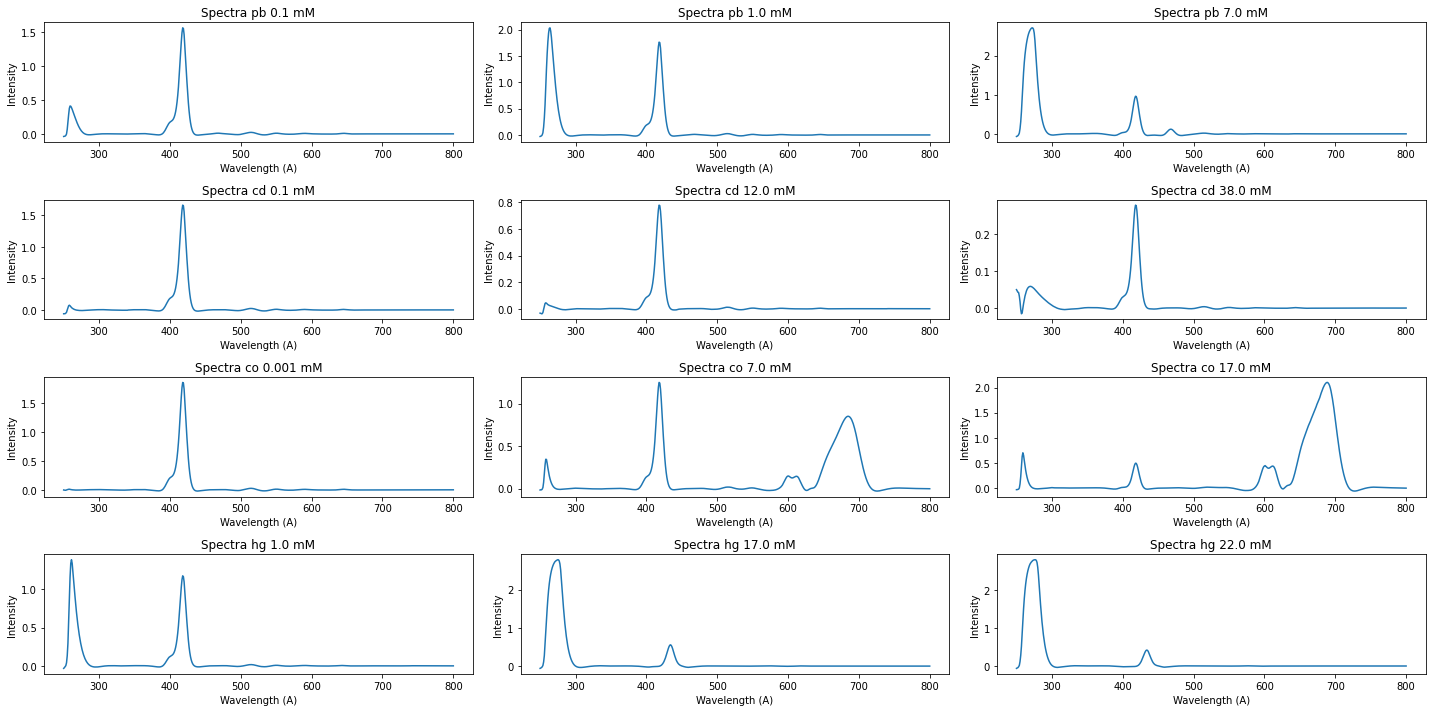

In [ ]:
y = np.arange(800,800-features_dim,-1)

fig, axs = plt.subplots(nrows=num_metals, ncols=max(num_sheets_test), figsize=(20, 10))

# plot spectra:
for i in range(num_metals):
    for j in range(num_sheets_test[i]):
        axs[i, j].set_title("Spectra "+metadata_test[i].name+' '+str(embedded_test[sum(num_sheets_test[:i])+j].concentration)+' mM')
        axs[i, j].plot(y, embedded_test[sum(num_sheets_test[:i])+j].spectra[:features_dim], color='C0')
        axs[i, j].set_xlabel("Wavelength (A)")
        axs[i, j].set_ylabel("Intensity")

fig.tight_layout()
plt.show()

# Shuffling training and test dataset

In [ ]:
def mix(embedded):
    return shuffle(np.asarray([emb.spectra for emb in embedded]),np.asarray([emb.label for emb in embedded]))

def mix_reg(embedded):
    return shuffle(np.asarray([emb.spectra for emb in embedded]),np.asarray([emb.concentration for emb in embedded]))

# Numerating the labels for classification

In [ ]:
targets = np.array([m.name for i,m in enumerate(metadata_train) for j in range(num_sheets[i])])
targets_test = np.array([m.name for i,m in enumerate(metadata_test) for j in range(num_sheets_test[i])])
encoder = LabelEncoder()
encoder.fit(targets)
# Numerical encoding of identities
y_label = encoder.transform(targets)
y_label_test = encoder.transform(targets_test)
for i in range(sum(num_sheets)):
    embedded_train[i].label = y_label[i]
for i in range(sum(num_sheets_test)):
    embedded_test[i].label = y_label_test[i]
print("Tagert metals and their corresponding labels")
print(targets)
print(y_label)

Tagert metals and their corresponding labels
['pb' 'pb' 'pb' 'pb' 'cd' 'cd' 'cd' 'cd' 'cd' 'cd' 'cd' 'co' 'co' 'co'
 'co' 'co' 'hg' 'hg' 'hg' 'hg' 'hg' 'hg']
[3 3 3 3 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2]


# Performing Classification by randomly selecting train and test dataset

In [ ]:
train_features, train_labels = mix(embedded_train)
test_features, test_labels = mix(embedded_test)
svc = LinearSVC(dual=False,max_iter=10000)
svc.fit(train_features,train_labels)
y_pred_svc = svc.predict(test_features)
acc_svc = accuracy_score(test_labels, y_pred_svc)
print("Accuracy of classification model: "+str(acc_svc*100)+"%")

Accuracy of classification model: 100.0%


#Regression for Concentration

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
X_train = [[],[],[],[]]
Y_train = [[],[],[],[]]
X_test = [[],[],[],[]]
Y_test = [[],[],[],[]]
reg_models = [None,None,None,None]
for feature in embedded_train:
    X_train[feature.label].append(feature.spectra)
    Y_train[feature.label].append(feature.concentration)

for feature in embedded_test:
    X_test[feature.label].append(feature.spectra)
    Y_test[feature.label].append(feature.concentration)

for i in range(len(X_train)):
    # create linear regression object
    reg = linear_model.LinearRegression()
    
    # train the model using the training sets
    reg.fit(np.asarray(X_train[i]),np.asarray(Y_train[i]))
    reg_models[i] = reg

ymodel = []
ytest = []
for i in range(len(reg_models)):

    print('Variance score: {} of {}'.format(reg_models[i].score(np.asarray(X_test[i]),Y_test[i]),encoder.inverse_transform([i])[0]))
    result = reg_models[i].predict(np.asarray(X_test[i]))
    for j in range(len(result)):
        if result[j]<0:
            result[j] = 0.001
    print(result)
    print(Y_test[i])
    print('\n')
    ymodel+=list(result)
    ytest+=Y_test[i]

error = mean_absolute_error(ytest, ymodel)
print('Final MAE Error on test dataset: %.3f' % error)

Variance score: 0.9764846930353767 of cd
[ 1.31332956 13.94612427 41.52255907]
[0.1, 12.0, 38.0]


Variance score: 0.9977211376498004 of co
[1.00000000e-03 7.19389910e+00 1.64599315e+01]
[0.001, 7.0, 17.0]


Variance score: 0.9833685620071657 of hg
[ 2.83750407 17.20793729 21.23647292]
[1.0, 17.0, 22.0]


Variance score: 0.9493417899794784 of pb
[0.26589221 0.55566338 5.90429622]
[0.1, 1.0, 7.0]


Final MAE Error on test dataset: 0.994
